# Purposes of this document

the goal
1. add mean gaussian rates to the neurons
2. correct the added offsets

and then we use variance decomposition to meaure the noisiness of features/neurons


# ideas

# Experimental setup related to the questions

this part should be configured to directly test the hypothesis put forward in the previous section


In [1]:
mean_firing_rate = 100

In [2]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)

noise_mode = 'relative_gaussian'

n_neurons = 32

n_neurons_per_group = 8

high_noise_neuron_ind = np.arange(n_neurons_per_group)
medium_noise_neuron_ind = np.arange(n_neurons_per_group, 2 * n_neurons_per_group)
low_noise_neuron_ind = np.arange(2*n_neurons_per_group, 3 * n_neurons_per_group)
no_noise_neuron_ind = np.arange(3 * n_neurons_per_group, 4* n_neurons_per_group)

neuron_type_indices_in_a_list = [
    high_noise_neuron_ind,
    medium_noise_neuron_ind,
    low_noise_neuron_ind,
    no_noise_neuron_ind
]

N_TYPES_OF_NEURONS = len(neuron_type_indices_in_a_list)


percent_of_count = np.ones(n_neurons)[:, np.newaxis]

print(f'set up the variances in a list:')

percent_of_count[high_noise_neuron_ind] =  1
percent_of_count[medium_noise_neuron_ind] = 0.5
percent_of_count[low_noise_neuron_ind] = 0.25
percent_of_count[no_noise_neuron_ind] = 0

print(f'we therefore know the number of neurons to be {n_neurons}')
print(percent_of_count)

set up the variances in a list:
we therefore know the number of neurons to be 32
[[1.  ]
 [1.  ]
 [1.  ]
 [1.  ]
 [1.  ]
 [1.  ]
 [1.  ]
 [1.  ]
 [0.5 ]
 [0.5 ]
 [0.5 ]
 [0.5 ]
 [0.5 ]
 [0.5 ]
 [0.5 ]
 [0.5 ]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]


In [3]:

#for comparision
exp_conds = ['neurons with three types of noises']
print(f'we have experimental conditions {exp_conds}')

#setting clda parameters 
##learner: collects paird data at batch_sizes
RHO = 0.5
batch_size = 100


#assistor set up assist level
assist_level = (0.05, 0.0)

#learner and updater: actualy set up rho
UPDATER_BATCH_TIME = 1
UPDATER_HALF_LIFE = np.log(RHO)  * UPDATER_BATCH_TIME / np.log(0.5)


we have experimental conditions ['neurons with three types of noises']


In [4]:
# CHANGE: game mechanics: generate task params
N_TARGETS = 8
N_TRIALS = 80

NUM_EXP = len(exp_conds) # how many experiments we are running. 

# Config the experiments

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

## load dependant libraries

In [5]:
GLOBAL_FIGURE_VERTICAL_SIZE = 4

In [6]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow
from riglib.bmi import train


from behaviour_metrics import calc_inter_wait_times, filter_state, sort_trials

from weights import calc_p_values_for_spike_batches_use_intended_kin
from weights import calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts
import weights

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import itertools #for identical sequences

np.set_printoptions(precision=2, suppress=True)


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/blackrock/cerelink.py:13: UserWarning: Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system
  warnings.warn("Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system")


##  behaviour and task setup

In [7]:
seq = SimBMIControlMulti.sim_target_seq_generator_multi(
N_TARGETS, N_TRIALS)

#create a second version of the tasks
seqs = itertools.tee(seq, NUM_EXP + 1)
target_seq = list(seqs[NUM_EXP])

seqs = seqs[:NUM_EXP]


SAVE_HDF = False
SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist
DEBUG_FEATURE = False


#base_class = SimBMIControlMulti
base_class = BMIControlMultiNoWindow

#for adding experimental features such as encoder, decoder
feats = []

## encoder

the cosine tuned encoder uses a poisson process, right
https://en.wikipedia.org/wiki/Poisson_distribution
so if the lambda is 1, then it's very likely 

In [8]:
from features.simulation_features import get_enc_setup

ENCODER_TYPE = 'cosine_tuned_encoder_with_poisson_noise'

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'rot_90', n_neurons= n_neurons)

#multiply our the neurons
sim_C = sim_C * mean_firing_rate

#im_C = sim_C * np.tile(percent_of_count,(1, N_STATES))
print(sim_C)


#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)

#set up the encoder
from features.simulation_features import SimCosineTunedEncWithNoise
feats.append(SimCosineTunedEncWithNoise)
print(f'{__name__}: selected SimCosineTunedEnc\n')

features.simulation_features: get_enc_setup has a tuning_level of 1 

[[   0.    0.    0.  100.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  100.    0.]
 [   0.    0.    0. -100.    0.    0.    0.]
 [   0.    0.    0.   -0.    0. -100.    0.]
 [   0.    0.    0.  100.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  100.    0.]
 [   0.    0.    0. -100.    0.    0.    0.]
 [   0.    0.    0.   -0.    0. -100.    0.]
 [   0.    0.    0.  100.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  100.    0.]
 [   0.    0.    0. -100.    0.    0.    0.]
 [   0.    0.    0.   -0.    0. -100.    0.]
 [   0.    0.    0.  100.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  100.    0.]
 [   0.    0.    0. -100.    0.    0.    0.]
 [   0.    0.    0.   -0.    0. -100.    0.]
 [   0.    0.    0.  100.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  100.    0.]
 [   0.    0.    0. -100.    0.    0.    0.]
 [   0.    0.    0.   -0.    0. -100.    0.]
 [   0.    0.    0.  100.    0

## decoder setup

In [9]:
#clda on random 
DECODER_MODE = 'random' # random 

   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')

__main__: set base class 
__main__: selected SimKFDecoderRandom 



##  clda: learner and updater

In [10]:


LEARNER_TYPE = 'feedback' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'smooth_batch' #none or "smooth_batch"


#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)

#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')
    



## assistor setup

## (Check) config the experiment

In [11]:
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: feats.append(SaveHDF)
if SAVE_SIM_HDF: feats.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)


kwargs_exps = list()

for i in range(NUM_EXP):
    d = dict()
    
    d['assist_level'] = assist_level
    d['sim_C'] = sim_C
    
    d['noise_mode'] = noise_mode
    d['percent_noise'] = percent_of_count
    
    d['batch_size'] = batch_size
    
    d['batch_time'] = UPDATER_BATCH_TIME
    d['half_life'] = UPDATER_HALF_LIFE
    
    kwargs_exps.append(d)


kwargs_exps

[{'assist_level': (0.05, 0.0),
  'sim_C': array([[   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.,    0., -100.,    0.],
         [   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.,    0., -100.,    0.],
         [   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.,    0., -100.,    0.],
         [   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.,    0., -100.,    0.],


## make and initalize experiment instances

In [12]:
#seed the experiment
np.random.seed(0)

#spawn the task
Exp = experiment.make(base_class, feats=feats)

exps = list()#create a list of experiment

for i,s in enumerate(seqs):
    e = Exp(s, **kwargs_exps[i])
    exps.append(e)

#run the ini
for e in exps: e.init()

metaclass constructor
(<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEncWithNoise'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>, <class 'bmimultitasks.BMIControlMultiNoWindow'>)
[<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEncWithNoise'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>]

features.simulatio

# Pre-experiment check: check the Kalman filter before training

we replace the encoder using the weights
assume, they are all randomly initialized get the first decoder
get a handle to the first decoder
we check the new decoder C matrix:


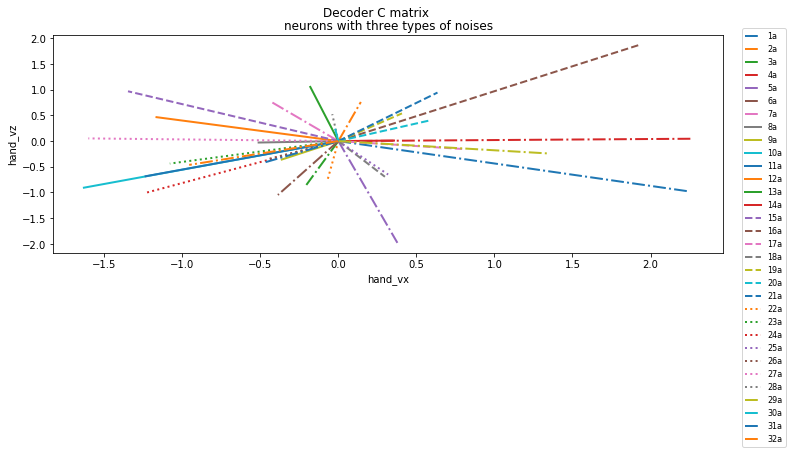

In [13]:
print('we replace the encoder using the weights')
print('assume, they are all randomly initialized get the first decoder')
print('get a handle to the first decoder')
first_decoder = exps[0].decoder
target_C = first_decoder.filt.C
    
#replace the decoder
for i,e in enumerate(exps):
    weights.change_target_kalman_filter_with_a_C_mat(e.decoder.filt, target_C, debug=False)
    
print('we check the new decoder C matrix:')

decoder_c_figure, axs = plt.subplots(nrows=1, 
                               ncols=NUM_EXP, figsize = [12,4],squeeze = False)
decoder_c_figure.suptitle('Decoder C matrix ')

for i,e in enumerate(exps):
    e.decoder.plot_C(ax = axs[0,i])
    axs[0,i].set_title(exp_conds[i])

# Experiment run: assemble into a complete loop

##  define the function

In [14]:
#make this into a loop

def run_exp_loop(exp,  **kwargs):
        # riglib.experiment: line 597 - 601
    #exp.next_trial = next(exp.gen)
    # -+exp._parse_next_trial()np.arraynp.array


    # we need to set the initial state
    # per fsm.run:  line 138


    # Initialize the FSM before the loop
    exp.set_state(exp.state)
    
    finished_trials = exp.calc_state_occurrences('wait')
    print(f'finished: {finished_trials}')


    while exp.state is not None:

        # exp.fsm_tick()

        ### Execute commands#####
        exp.exec_state_specific_actions(exp.state)

        ###run the bmi loop #####
        # _cycle

        # bmi feature extraction, eh
        #riglib.bmi: 1202
        feature_data = exp.get_features()

        # Determine the target_state and save to file
        current_assist_level = exp.get_current_assist_level()
        target_state = exp.get_target_BMI_state(exp.decoder.states)

        # Determine the assistive control inputs to the Decoder
        #update assistive control level
        exp.update_level()
        if np.any(current_assist_level) > 0:
            current_state = exp.get_current_state()

            if target_state.shape[1] > 1:
                assist_kwargs = exp.assister(current_state, 
                                             target_state[:,0].reshape(-1,1), 
                                             current_assist_level, mode= exp.state)
            else:
                assist_kwargs = exp.assister(current_state, 
                                              target_state, 
                                              current_assist_level, 
                                              mode= exp.state)

            kwargs.update(assist_kwargs)
            
        

        # decode the new features
        # riglib.bmi.bmiloop: line 1245
        neural_features = feature_data[exp.extractor.feature_type]

        # call decoder.
        #tmp = exp.call_decoder(neural_features, target_state, **kwargs)
        neural_obs = neural_features
        learn_flag = exp.learn_flag
        task_state = exp.state

        n_units, n_obs = neural_obs.shape
        # If the target is specified as a 1D position, tile to match
        # the number of dimensions as the neural features
        if np.ndim(target_state) == 1 or (target_state.shape[1] == 1 and n_obs > 1):
            target_state = np.tile(target_state, [1, n_obs])

        decoded_states = np.zeros([exp.bmi_system.decoder.n_states, n_obs])
        update_flag = False

        for k in range(n_obs):
            neural_obs_k = neural_obs[:, k].reshape(-1, 1)
            target_state_k = target_state[:, k]

            # NOTE: the conditional below is *only* for compatibility with older Carmena
            # lab data collected using a different MATLAB-based system. In all python cases,
            # the task_state should never contain NaN values.
            if np.any(np.isnan(target_state_k)):
                task_state = 'no_target'

            #################################
            # Decode the current observation
            #################################
            decodable_obs, decode = exp.bmi_system.feature_accumulator(
                neural_obs_k)
            if decode:  # if a new decodable observation is available from the feature accumulator
                prev_state = exp.bmi_system.decoder.get_state()

                exp.bmi_system.decoder(decodable_obs, **kwargs)
                # Determine whether the current state or previous state should be given to the learner
                if exp.bmi_system.learner.input_state_index == 0:
                    learner_state = exp.bmi_system.decoder.get_state()
                elif exp.bmi_system.learner.input_state_index == -1:
                    learner_state = prev_state
                else:
                    print(("Not implemented yet: %d" %
                           exp.bmi_system.learner.input_state_index))
                    learner_state = prev_state

                if learn_flag:
                    exp.bmi_system.learner(decodable_obs.copy(), learner_state, target_state_k, exp.bmi_system.decoder.get_state(
                    ), task_state, state_order=exp.bmi_system.decoder.ssm.state_order)

            decoded_states[:, k] = exp.bmi_system.decoder.get_state()

            ############################
            # Update decoder parameters
            ############################
            if exp.bmi_system.learner.is_ready():
                batch_data = exp.bmi_system.learner.get_batch()
                batch_data['decoder'] = exp.bmi_system.decoder
                kwargs.update(batch_data)
                exp.bmi_system.updater(**kwargs)
                exp.bmi_system.learner.disable()

            new_params = None  # by default, no new parameters are available
            if exp.bmi_system.has_updater:
                new_params = copy.deepcopy(exp.bmi_system.updater.get_result())

            # Update the decoder if new parameters are available
            if not (new_params is None):
                exp.bmi_system.decoder.update_params(
                    new_params, **exp.bmi_system.updater.update_kwargs)
                new_params['intended_kin'] = batch_data['intended_kin']
                new_params['spike_counts_batch'] = batch_data['spike_counts']

                exp.bmi_system.learner.enable()
                update_flag = True

                # Save new parameters to parameter history
                exp.bmi_system.param_hist.append(new_params)



        # saved as task data
        # return decoded_states, update_flag
        tmp = decoded_states
        exp.task_data['internal_decoder_state'] = tmp

        # reset the plant position
        # @riglib.bmi.BMILoop.move_plant  line:1254
        exp.plant.drive(exp.decoder)

        # check state transitions and run the FSM.
        current_state = exp.state

        # iterate over the possible events which could move the task out of the current state
        for event in exp.status[current_state]:
            # if the event has occurred
            if exp.test_state_transition_event(event):
                # execute commands to end the current state
                exp.end_state(current_state)

                # trigger the transition for the event
                exp.trigger_event(event)

                # stop searching for transition events (transition events must be
                # mutually exclusive for this FSM to function properly)
                break

        # sort out the loop params.
        # inc cycle count
        exp.cycle_count += 1

        # save target data as was done in manualControlTasks._cycle
        exp.task_data['target'] = exp.target_location.copy()
        exp.task_data['target_index'] = exp.target_index

        #done in bmi:_cycle after move_plant
        exp.task_data['loop_time'] = exp.iter_time()


        #fb_controller data
        exp.task_data['target_state'] = target_state

        #encoder data
        #input to this is actually extractor
        exp.task_data['ctrl_input'] = np.reshape(exp.extractor.sim_ctrl, (1,-1))

        #actually output
        exp.task_data['spike_counts'] = feature_data['spike_counts']


        #save the decoder_state
        #from BMILoop.move_plant
        exp.task_data['decoder_state'] = exp.decoder.get_state(shape=(-1,1))
        
        #save bmi_data
        exp.task_data['update_bmi'] = update_flag


        # as well as plant data.
        plant_data = exp.plant.get_data_to_save()
        for key in plant_data:
            exp.task_data[key] = plant_data[key]

        # clda data handled in the above call.

        # save to the list hisory of data.
        exp.task_data_hist.append(exp.task_data.copy())
        
        #print out the trial update whenever wait count changes, alright. 
        if finished_trials != exp.calc_state_occurrences('wait'):
            finished_trials = exp.calc_state_occurrences('wait')
            print(f'finished trials :{finished_trials} with a current assist level of {exp.get_current_assist_level()}')


    if exp.verbose:
        print("end of FSM.run, task state is", exp.state)
    
    


## actually running the experiments

In [15]:
for i,e in enumerate(exps):
    run_exp_loop(e, **kwargs_exps[i])
    print(f'Finished running  {exp_conds[i]}')

runseq
finished: 1
assist_level:  0.05
KFSmoothbatch: calculating new SB parameters


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:372: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


KFSmoothbatch: calculating new SB parameters
finished trials :2 with a current assist level of 0.048038888888888895
finished trials :3 with a current assist level of 0.047856944444444445
finished trials :4 with a current assist level of 0.04767361111111111
KFSmoothbatch: calculating new SB parameters
finished trials :5 with a current assist level of 0.04724166666666667
finished trials :6 with a current assist level of 0.04704027777777778
finished trials :7 with a current assist level of 0.04683888888888889
KFSmoothbatch: calculating new SB parameters
finished trials :8 with a current assist level of 0.04664027777777778
finished trials :9 with a current assist level of 0.04644166666666667
finished trials :10 with a current assist level of 0.04624166666666667
finished trials :11 with a current assist level of 0.046033333333333336
KFSmoothbatch: calculating new SB parameters
finished trials :12 with a current assist level of 0.045831944444444446
finished trials :13 with a current assist l

# Postprocessing the data for loading

In [16]:
for e in  exps: print(e.calc_state_occurrences('reward'))

80


## declare defs and conventions

In [71]:
FRAME_RATE = 60
INT_WINDOW_TIME = 10 # s for looking at sample raw data

# some conventions as we go down the loop
X_VEL_STATE_IND = 3
Y_VEL_STATE_IND = 5
X_POS_STATE_IND = 0
Y_POS_STATE_IND = 2
CONSTANTE_STATE_IND = 6

state_indices = [X_POS_STATE_IND,
                 Y_POS_STATE_IND,
                 X_VEL_STATE_IND,
                 Y_VEL_STATE_IND]
state_names = ['x pos ', 'y pos', 'x vel', 'y vel']


INT_WIN_SAMPLES = INT_WINDOW_TIME * FRAME_RATE



## Refactor out the data

In [18]:
task_data_hist_np_all = [np.array(e.task_data_hist) for e in exps]
len(task_data_hist_np_all)
task_data_hist_np_all[0].dtype

dtype([('cursor', '<f8', (3,)), ('obs_t', '<f8', (32, 1)), ('K', '<f8', (7, 32)), ('KC', '<f8', (7, 7)), ('pred_state_mean', '<f8', (7, 1)), ('post_state_mean', '<f8', (7, 1)), ('pred_state_P', '<f8', (7, 7)), ('post_state_P', '<f8', (7, 7)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (32, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

## Finished time in seconds

In [19]:
finished_times_in_seconds = [int(len(s)/FRAME_RATE) for s in task_data_hist_np_all]
finished_times_in_seconds

[225]

# Post data analysis

## Overall  trial statistics succuss rate)

In [20]:
state_logs = [e.state_log for e in exps]


In [21]:
STATE_CUT_NAME =  'wait'
#get the state logs
wait_logs = [filter_state(s, STATE_CUT_NAME) for s in state_logs]

inter_wait_times = [calc_inter_wait_times(w) for w in wait_logs]
#this has both start times 

Text(0, 0.5, 'Trial time (s)')

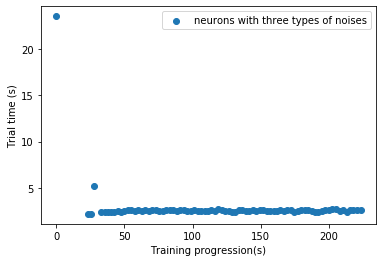

In [22]:
for i in inter_wait_times:
    plt.scatter(i[:,0], i[:,1])

plt.legend(exp_conds)
plt.xlabel('Training progression(s)')
plt.ylabel('Trial time (s)')

In [23]:
wait_time = inter_wait_times[0]
task_data_hist_np = task_data_hist_np_all[0]



In [24]:
def sort_trials(wait_time:list, 
                target_seq:list,
                task_data_hist_np:dict, 
                dict_keys, FRAME_RATE = 60):
    trial_dict = list()
    
    for i,row in enumerate(wait_time):
        start_time = row[0]
        inter_wait_time = row[1]

        start_sample = int(start_time * FRAME_RATE)
        inter_wait_sample = int(inter_wait_time * FRAME_RATE)
        stop_sample = start_sample + inter_wait_sample

        single_trial_dict = dict()

        for k in dict_keys:
            
            requested_type_data = np.squeeze(task_data_hist_np[k])
            single_trial_dict[k] =  requested_type_data[start_sample:stop_sample,
                                                       :]
        #add more info
        single_trial_dict['start_time'] = row[0]
        single_trial_dict['inter_wait_time'] = row[1]
        
        #add target info
        single_trial_dict['targets'] = target_seq[i]

        #add the dictionary to the list
        trial_dict.append(single_trial_dict)
        
    return trial_dict



In [25]:


trial_dicts_all = []
dict_keys = ['cursor', #behaviour
             'ctrl_input', 'spike_counts', #encoder translates intended ctrl into spike counts
             'decoder_state']

for i in range(NUM_EXP):
    wait_time = inter_wait_times[i]
    task_data_hist_np = task_data_hist_np_all[i]
    
    trial_dict_0 = sort_trials(wait_time, 
                               target_seq,
                               task_data_hist_np, dict_keys)
    
    trial_dicts_all.append(trial_dict_0)

len(trial_dicts_all)

1

## Trajectory analysis

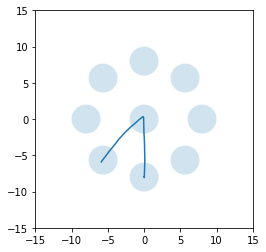

In [26]:
n_roi_trials = N_TRIALS - 1
unique_targets =  np.unique(target_seq, axis = 0)


X_CURSOR = 0
Z_CURSOR = 2
CIRCL_ALPHA = 0.2



RANGE_LIM =  15
figure, axes = plt.subplots() 

axes.set_xlim(-RANGE_LIM, RANGE_LIM)
axes.set_ylim(-RANGE_LIM, RANGE_LIM)

CIRCLE_RADIUS = exps[0].target_radius

#plot the targets

#plot the origin

cc = plt.Circle((0,0 ), 
            radius = CIRCLE_RADIUS,
            alpha = CIRCL_ALPHA)

axes.add_artist( cc ) 

for origin_t in unique_targets:
    origin = origin_t[0]
    t = origin_t[1]

    cc = plt.Circle((t[X_CURSOR],t[Z_CURSOR] ), 
                    radius = CIRCLE_RADIUS,
                    alpha = CIRCL_ALPHA)
                     
    axes.set_aspect( 1 ) 
    axes.add_artist( cc ) 
    
    
for trial_dict in trial_dicts_all:
    
    sample_trial = trial_dict[n_roi_trials]
    trial_cursor_trajectory = sample_trial['cursor']
    
    
    axes.plot(trial_cursor_trajectory[:, X_CURSOR], 
             trial_cursor_trajectory[:, Z_CURSOR])
    N_TRIALS = 80



In [27]:
print('finished trials:')

for i,e in  enumerate(exps): 
    reward_num = e.calc_state_occurrences('reward')
    print(f'{exp_conds[i]}: {reward_num} out of {N_TRIALS}')

finished trials:
neurons with three types of noises: 80 out of 80


## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

In [28]:
print('the encoder observation Q matrix')
for i,e in enumerate(exps):
    print(exp_conds[i])
    print(e.encoder.ssm.w)

the encoder observation Q matrix
neurons with three types of noises
7


In [29]:
n_exp = 0


spike_count_sample = trial_dicts_all[n_exp][n_roi_trials]['spike_counts']

## decoder

steady state tuning curves:


Text(0, -0.27999999999999997, 'CLDA rho 0.5')

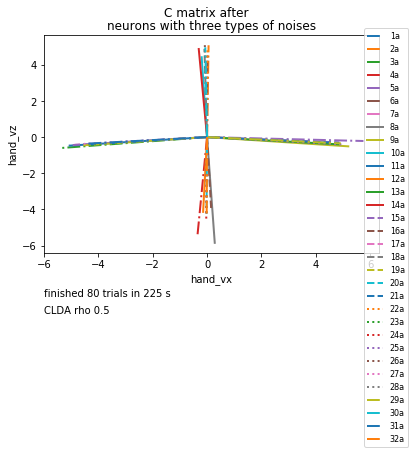

In [30]:
TEXT_OFFSET_VERTICAL = -0.2

figure_decoder_c_after,axs = plt.subplots()

figure_decoder_c_after.suptitle('C matrix after')

print('steady state tuning curves:')
e = exps[0]

e.decoder.plot_C(ax = axs)
axs.set_title(exp_conds[i])

#get the lower left coordinate
y_lim_range  = axs.get_ylim()[1] - axs.get_ylim()[0]

axs.text(0, TEXT_OFFSET_VERTICAL,
            f'finished {N_TRIALS} trials in {finished_times_in_seconds[i]} s', 
           transform = axs.transAxes)

figure_decoder_c_after.text(0, 1.4 * TEXT_OFFSET_VERTICAL, 
                 f'CLDA rho {RHO}',
                transform = axs.transAxes)


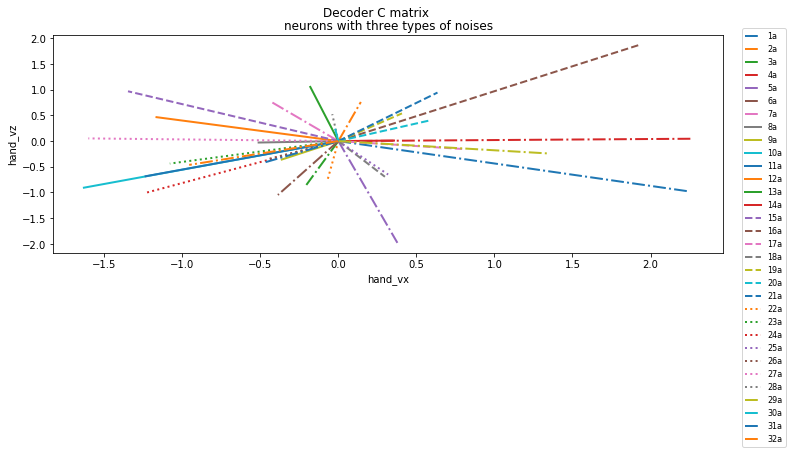

In [31]:
decoder_c_figure

# CLDA updates

## clda update frequencies

In [32]:

clda_params_all = [np.array(e.bmi_system.param_hist) for e in exps]

for c in clda_params_all:
    print(f'did clda for {len(c)} times')

did clda for 22 times


In [33]:
update_bmi_all = np.squeeze(task_data_hist_np_all[0]['update_bmi'])

Text(0.5, 0, 'frame count')

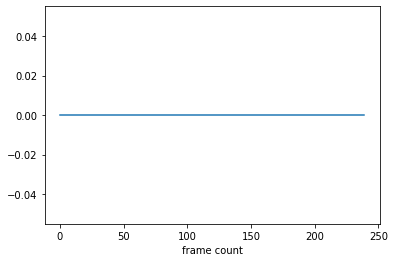

In [34]:
plt.plot(update_bmi_all[:240])
plt.xlabel('frame count')

## reformat the matrix

In [35]:
clda_params = clda_params_all[0]

clda_params_dict_all = list()

for p in clda_params_all:
    clda_params_dict = dict()
    for param_key in p[0].keys():
        clda_params_dict[param_key] = np.array([ record_i[param_key] for record_i in p])
    
    clda_params_dict_all.append(clda_params_dict)


len(clda_params_dict_all)

1

## observation covariance matrix

In [36]:
n_sample = 1

for i,c in enumerate(clda_params_dict_all):
    print(exp_conds[i])
    print(c['kf.Q'][n_sample,:,:])
    print()

neurons with three types of noises
[[1371.49  104.26  311.65 ...  139.83  296.62  122.66]
 [ 104.26 3335.85  382.11 ...  286.25  234.02  279.42]
 [ 311.65  382.11 1204.05 ...  222.78  368.54  217.14]
 ...
 [ 139.83  286.25  222.78 ...  433.93  178.86  391.91]
 [ 296.62  234.02  368.54 ...  178.86  346.8   175.63]
 [ 122.66  279.42  217.14 ...  391.91  175.63  423.39]]



## clda C matrix

In [37]:
print('we need to remind ourself this does not include the Kalman weights, right')
print('we include the weights from the initial random recorder')
print(f'clda params dict has params of {clda_params_dict.keys()}\n')

kf_C = clda_params_dict['kf.C']
spike_counts_batch =  clda_params_dict['spike_counts_batch']
intended_kin = clda_params_dict['intended_kin']
mFR = clda_params_dict['mFR']


print(f'kf_C has the shape of {kf_C.shape}')
print(f'mFR has the shape of {mFR.shape}')
print(f'spike_counts batch has the shape of {spike_counts_batch.shape}')
print(f'intended kin has the shape of {intended_kin.shape}')

we need to remind ourself this does not include the Kalman weights, right
we include the weights from the initial random recorder
clda params dict has params of dict_keys(['kf.C', 'kf.Q', 'kf.C_xpose_Q_inv_C', 'kf.C_xpose_Q_inv', 'mFR', 'sdFR', 'rho', 'intended_kin', 'spike_counts_batch'])

kf_C has the shape of (22, 32, 7)
mFR has the shape of (22, 32)
spike_counts batch has the shape of (22, 32, 100)
intended kin has the shape of (22, 7, 100)


In [38]:
print('K matrix before:')
print(kf_C[0,:,:])
print('K matrix after:')
print(kf_C[-1,:,:])

K matrix before:
[[ 0.    0.    0.    3.02  0.    0.23  1.32]
 [ 0.    0.    0.   -0.12  0.    4.5  12.98]
 [ 0.    0.    0.   -1.33  0.   -0.43  5.98]
 [ 0.    0.    0.    1.17  0.   -0.09  1.12]
 [ 0.    0.    0.    4.27  0.   -1.06  8.14]
 [ 0.    0.    0.   -0.29  0.    4.44  7.14]
 [ 0.    0.    0.   -1.27  0.    0.39  5.71]
 [ 0.    0.    0.    0.12  0.   -0.87  8.57]
 [ 0.    0.    0.    3.88  0.    0.22  0.68]
 [ 0.    0.    0.   -0.53  0.    4.43  5.41]
 [ 0.    0.    0.   -1.6   0.   -0.45  6.44]
 [ 0.    0.    0.   -0.5   0.   -0.04  2.08]
 [ 0.    0.    0.    4.04  0.    0.34  7.41]
 [ 0.    0.    0.   -0.46  0.    4.83 11.67]
 [ 0.    0.    0.   -1.63  0.    0.4   6.1 ]
 [ 0.    0.    0.    1.07  0.    0.64  3.42]
 [ 0.    0.    0.    4.27  0.   -0.21  7.34]
 [ 0.    0.    0.    0.31  0.    4.13  6.86]
 [ 0.    0.    0.   -0.76  0.    0.15  6.58]
 [ 0.    0.    0.    0.72  0.   -0.59  6.72]
 [ 0.    0.    0.    4.34  0.    0.55  4.56]
 [ 0.    0.    0.    0.75  0.    4.45 

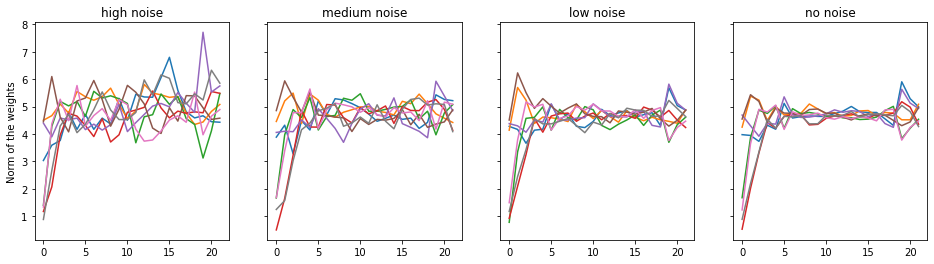

In [40]:
from weights_linear_regression import calc_a_history_of_matrix_L2norms_along_first_axis

N_CLDA_ROI_TIME = 90

the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(kf_C, 
                                                                        indices_to_sum=(X_VEL_STATE_IND, Y_VEL_STATE_IND))

figure_weights_norm, axes_weights_norm = plt.subplots( 1, N_TYPES_OF_NEURONS,
    figsize = (N_TYPES_OF_NEURONS * GLOBAL_FIGURE_VERTICAL_SIZE, GLOBAL_FIGURE_VERTICAL_SIZE),
                                                     sharey= True)

title_list = ['high noise', 'medium noise', 'low noise', 'no noise']

axes_weights_norm[0].set_ylabel('Norm of the weights')

for i,a in enumerate(axes_weights_norm):
    a.plot(the_history_of_KF_weights_in_time_by_neurons[:N_CLDA_ROI_TIME,
                                                        neuron_type_indices_in_a_list[i]])
    a.set_title(title_list[i])
    
    


## plot the mfr

the first couple of batches


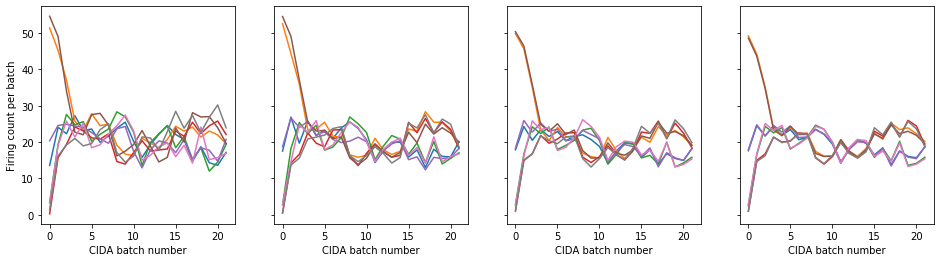

In [41]:
figure_clda_mfr, axes_clda_mfr = \
plt.subplots(1, N_TYPES_OF_NEURONS, 
             figsize = (N_TYPES_OF_NEURONS * GLOBAL_FIGURE_VERTICAL_SIZE,
                        GLOBAL_FIGURE_VERTICAL_SIZE),
            sharey = True)


for i,a in enumerate(axes_clda_mfr):
    a.plot(mFR[:,
               neuron_type_indices_in_a_list[i]])
    a.set_xlabel('ClDA batch number')

    
axes_clda_mfr[0].set_ylabel('Firing count per batch')
print(f'the first couple of batches')

clda basically picks up the the noise
and treating the my poisson noise as a constant term. 

## examine training batches

we find out the covariance of the 
spike counts:
they encode the same states, albeit at different values
neurons that encode the same direction have the proportional firing rates 
they have the same learned targets
as a result, the linear fit be more or less the same
which of course violates my assumption that the noise should decrease the correlation


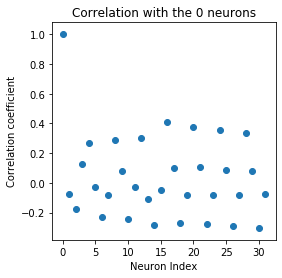

In [42]:

training_sample_point = 0
print('we find out the covariance of the ')

spike_counts_one_batch = spike_counts_batch[training_sample_point,:,:]

print('spike counts:')
spike_counts_one_batch_cov = np.corrcoef(spike_counts_one_batch)

figure_corrcov, axes_corrcov = plt.subplots(1,1,
                                           figsize = (GLOBAL_FIGURE_VERTICAL_SIZE, GLOBAL_FIGURE_VERTICAL_SIZE))

neuron_roi = 0

axes_corrcov.scatter(range(N_NEURONS), 
                     spike_counts_one_batch_cov[neuron_roi, :])
axes_corrcov.set_title(f'Correlation with the {neuron_roi} neurons')
axes_corrcov.set_xlabel('Neuron Index')
axes_corrcov.set_ylabel('Correlation coefficient')

print(f'they encode the same states, albeit at different values')
print(f'neurons that encode the same direction have the proportional firing rates ')
print(f'they have the same learned targets')
print(f'as a result, the linear fit be more or less the same')
print(f'which of course violates my assumption that the noise should decrease the correlation')

In [43]:
training_sample_point = 2

print('intended kinematics:')
print(intended_kin[training_sample_point])

print('spike counts:')
print(spike_counts_batch[training_sample_point])

print('trained KF C matrix:')
#print(kf_C[training_sample_point])

intended kinematics:
[[ 10.64  10.89  10.8   10.44   9.12   7.19   5.32   3.44   1.5   -0.07
   -1.32  -2.07  -2.44  -2.39  -2.04  -1.6   -1.13  -0.73  -0.37  -0.16
   -0.03   0.08   0.15   0.19   0.21   0.26   1.24   2.51   3.86   5.32
    6.58   7.54   8.19   8.67   8.93   9.     8.94   7.92   6.73   5.37
    3.84   2.31   0.81  -0.46  -1.27  -1.63  -1.72  -1.07   0.1    1.38
    2.56   3.57   4.37   5.1    5.67   6.1    6.31   6.41   6.39   5.85
    5.21   4.01   2.85   2.07   1.28   0.62   0.07  -0.38  -0.6   -0.73
   -0.79  -0.77  -0.76  -0.74  -0.68  -0.58  -0.43  -0.29  -0.16  -0.03
    0.08   0.2    0.34   0.79   0.97   0.8    0.52   0.34   0.16   0.
   -0.67  -1.73  -3.02  -4.43  -5.47  -6.21  -6.73  -6.98  -7.02  -6.91]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.  

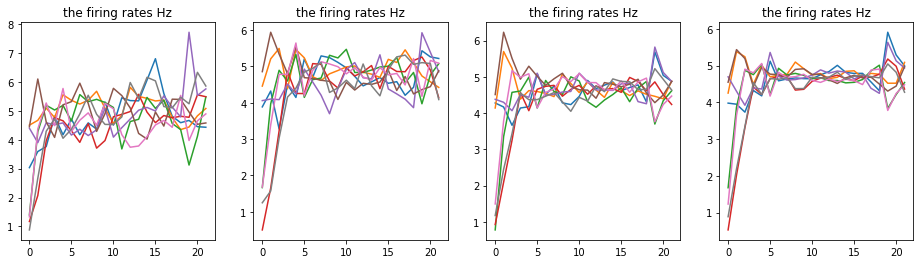

In [44]:
N_CLDA_ROI_TIME

# now, we can average over the neurons. 
from weights_linear_regression import calc_a_history_of_matrix_L2norms_along_first_axis

the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(kf_C, 
                                                                        indices_to_sum=(X_VEL_STATE_IND, Y_VEL_STATE_IND))

figure_weights_norm, axes_weights_norm = plt.subplots( 1, N_TYPES_OF_NEURONS,
    figsize = (N_TYPES_OF_NEURONS * GLOBAL_FIGURE_VERTICAL_SIZE, GLOBAL_FIGURE_VERTICAL_SIZE))

for i,a in enumerate(axes_weights_norm):
    a.plot(the_history_of_KF_weights_in_time_by_neurons[:N_CLDA_ROI_TIME,
                                                        neuron_type_indices_in_a_list[i]])
    a.set_title(f'the firing rates Hz')

we just count one batch
[ 2721. 10283.   684.    50.  4076. 10930.   657.   277.  3505. 10516.
   549.    99.  3748. 10914.   574.   102.  3578.  9979.   560.   234.
  3666. 10081.   551.   194.  3529.  9847.   522.   200.  3584.  9727.
   578.   195.]


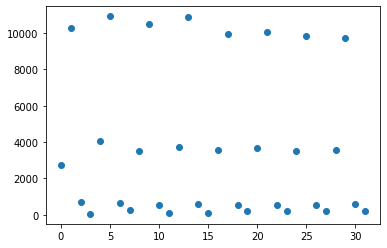

In [45]:
batch_of_interest = 0
spike_count_one_batch_in_neuron_by_frame = spike_counts_batch[batch_of_interest, :, :]

print(f'we just count one batch')
spike_count_sum_in_neuron = np.sum(spike_count_one_batch_in_neuron_by_frame, axis = 1)

figure_neuron_count_sum, axes_neuron_count_sum = plt.subplots()

print(spike_count_sum_in_neuron)

axes_neuron_count_sum.scatter(np.arange(len(spike_count_sum_in_neuron)), spike_count_sum_in_neuron)


## measure the variance

In [109]:
from weights_linear_regression import calc_average_ssm_for_each_X_column

#assem the vectors
batch_of_interest = -1
spike_counts_batch_one_batch = spike_counts_batch[batch_of_interest, :, :]
kf_C_one_batch =  kf_C[batch_of_interest, :, :]
intended_kin_one_batch = intended_kin[batch_of_interest, :, :]

#change the shapes
kf_C_2D_one_batch = kf_C_one_batch[:, (X_VEL_STATE_IND, Y_VEL_STATE_IND)]
intended_kin_2D_one_batch = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]

print(f'the shapes are {spike_counts_batch_one_batch.shape}')
print(f'the shapes are {kf_C_2D_one_batch.shape}')
print(f'the shapes are {intended_kin_2D_one_batch.shape}')

the shapes are (32, 100)
the shapes are (32, 2)
the shapes are (2, 100)


spike_ssms_one_batch shape ; (32,)


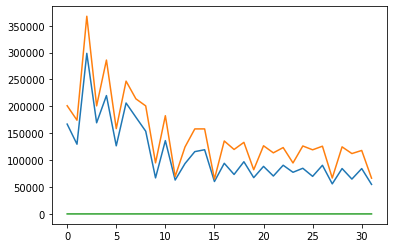

In [115]:
variance_tot = np.var(spike_counts_batch_one_batch, axis = 1)  * batch_size
firing_rate_residual = spike_counts_batch_one_batch - kf_C_2D_one_batch@intended_kin_2D_one_batch

firing_rate_residual_squared = firing_rate_residual**2
firing_rate_residual_across_neuron = np.sum(firing_rate_residual_squared, axis = 1)

fraction_of_accounted_ssm = 1 - firing_rate_residual_across_neuron / variance_tot



print(f'spike_ssms_one_batch shape ; {spike_ssms_one_batch.shape}')
figure_spike_ssm, axes_spike_count = plt.subplots()


axes_spike_count.plot(firing_rate_residual_across_neuron)
axes_spike_count.plot(variance_tot)
axes_spike_count.plot(fraction_of_accounted_ssm)

## mesure the variance by looking at ensemble neurons

In [117]:
print(f'the shapes are {spike_counts_batch.shape}')
print(f'the shapes are {kf_C_2D_one_batch.shape}')
print(f'the shapes are {intended_kin.shape}')

the shapes are (22, 32, 100)
the shapes are (32, 2)
the shapes are (22, 7, 100)


In [118]:
spike_counts_batch_reorder = np.transpose(spike_counts_batch, (0,2,1))
intended_kin_reorder = np.transpose(intended_kin, (0,2,1))

last_batch = -1
kf_C_one_batch =  kf_C[last_batch, :, :]

print(f'the shapes are {spike_counts_batch_reorder.shape}')
print(f'the shapes are {kf_C_2D_one_batch.shape}')
print(f'the shapes are {intended_kin_reorder.shape}')

spike_counts_batch_flatten = np.reshape(spike_counts_batch_reorder, (-1, n_neurons)).T
intended_kin_flatten = np.reshape(intended_kin_reorder, (-1, N_STATES))
print(f'the shapes are {spike_counts_batch_flatten.shape}')
print(f'the shapes are {intended_kin_flatten.shape}')

#add

                                        

#change the shapes
kf_C_2D_one_batch = kf_C_one_batch[:, (X_VEL_STATE_IND, Y_VEL_STATE_IND,CONSTANTE_STATE_IND)]


intended_kin_2D_flatten = intended_kin_flatten[:,(X_VEL_STATE_IND, Y_VEL_STATE_IND, CONSTANTE_STATE_IND)].T

print(f'\nthe shapes are {spike_counts_batch_flatten.shape}')
print(f'the shapes are {kf_C_2D_one_batch.shape}')
print(f'the shapes are {intended_kin_2D_flatten.shape}')

the shapes are (22, 100, 32)
the shapes are (32, 2)
the shapes are (22, 100, 7)
the shapes are (32, 2200)
the shapes are (2200, 7)

the shapes are (32, 2200)
the shapes are (32, 3)
the shapes are (3, 2200)


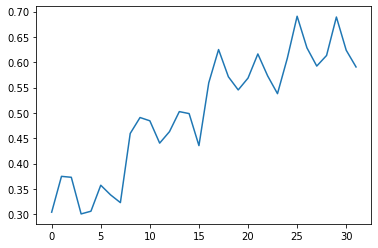

In [124]:
variance_tot = np.var(spike_counts_batch_flatten, axis = 1)  * batch_size * 22
firing_rate_residual = spike_counts_batch_flatten - kf_C_2D_one_batch@intended_kin_2D_flatten

firing_rate_residual_squared = firing_rate_residual**2
firing_rate_residual_across_neuron = np.sum(firing_rate_residual_squared, axis = 1)

fraction_of_accounted_ssm = 1 - firing_rate_residual_across_neuron / variance_tot

plt.plot(fraction_of_accounted_ssm)


## change the dim

In [92]:
spike_counts_batch_flatten = spike_counts_batch_flatten.T
intended_kin_2D_flatten = intended_kin_2D_flatten.T

print(f'\nthe shapes are {spike_counts_batch_flatten.shape}')
print(f'the shapes are {kf_C_2D_one_batch.shape}')
print(f'the shapes are {intended_kin_2D_flatten.shape}')


the shapes are (32, 2200)
the shapes are (32, 2)
the shapes are (2, 2200)


# feature analyses

In [ ]:
import statsmodels.api as sm


## Examine relevance of one neuron from one batch 

### Select data

In [ ]:
clda_params_dict.keys() # this is from one experiment

In [ ]:
spike_counts_batch = clda_params_dict['spike_counts_batch']
intended_kin = clda_params_dict['intended_kin']
print(f'{len(spike_counts_batch)}')
print(f'{len(intended_kin)}')

In [ ]:
# we just take one batch
batch_of_interest = 0
spike_count_one_batch = spike_counts_batch[batch_of_interest]
intended_kin_one_batch = intended_kin[batch_of_interest]

print(f'look at one batch: batch number {batch_of_interest}')
print(f'spike count')
print(spike_count_one_batch)

print(f'intended kin')
print(intended_kin_one_batch)

In [ ]:
print('we are dealing with a velocity decoder')
print('we only look at  x vel and y vel:')
print('We assume we are only interested how firing rates encode x, y vel')

intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
print('after selecting the vels:')
print(intended_kin_one_batch_2D)

In [ ]:
print('we will do  one neuron at a time')
n_roi_neuron = 0
print(f'the neuron that we are interested is neuron {n_roi_neuron}')
print('and selected firing rates:')

spike_count_one_batch_one_neuron = spike_count_one_batch[n_roi_neuron,:]

print(spike_count_one_batch_one_neuron)

### OLS model fitting

In [ ]:
print('we transpose the vector for fitting')
X = intended_kin_one_batch_2D.T
y = np.reshape(spike_count_one_batch_one_neuron, (-1,1))


print('the independent variables are  the intended kin hence, X')
print(X)


print('the dependent variable is the neuron spike connt, hence y')
print(y)


In [ ]:
print('we add the constant one to the states (X)')
X = sm.add_constant(X, has_constant= 'raise')
print('the new X is')
print(X)

In [ ]:
print('now we can fit using statsmodels.ols')

ols_spike_from_states = sm.OLS(y, X)

results_ols_spike_from_states = ols_spike_from_states.fit()

print('print results')
print(results_ols_spike_from_states.summary())

In [ ]:
print('the p-values test against if the coefficients are zero')
neuron_batch_pvalue = results_ols_spike_from_states.pvalues

print(f'the p values for this neuron of index {n_roi_neuron}')
print(neuron_batch_pvalue)

neuron_batch_coeff = results_ols_spike_from_states.params

print('the reg. coeff. are ')
print(neuron_batch_coeff)

print()
significance_level = 0.05
print(f'at a significance_level of {significance_level}:')
print('this array has the indix of the states that are significantly correlated with the firing rates  ')

np.where(neuron_batch_pvalue < significance_level)

## iterate up the model testing procedure

In [ ]:
print('we write a function that actually  check if any given neuron has a sig state')



        






In [ ]:
print('with the functions, we can fit and test the one neuron and against the state')

In [ ]:
significance_level = 0.05


    




In [ ]:
from weights import fit_ols

print('we transpose the vector for fitting')
X = intended_kin_one_batch_2D.T
y = np.reshape(spike_count_one_batch_one_neuron, (-1,1))


print('the independent variables are  the intended kin hence, X')
print(X)


print('the dependent variable is the neuron spike connt, hence y')
print(y)

results = fit_ols(y, X)

print('fitting_results:')
print(results)


## test across the neurons in a batch

In [ ]:
spike_count_one_batch.shape

In [ ]:


n_roi_neuron = 0

#assume spike_count_one_batch has the shape N_NEURONS by N_time points
#assume that intended_kin_one_batch_2D has N_states by N_Time_points

'''

'''
#get intended kinematics this is fixed for each neuron
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
#('we transpose the vector for fitting')
intended_kin_one_batch_2D = intended_kin_one_batch_2D.T
spike_count_one_batch = intended_kin_one_batch.T

neuron_batch_pvalue_matrix = calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts(spike_count_one_batch,
                                                                       intended_kin_one_batch_2D)

print(f'the pvalue matrix for a batch')
neuron_batch_pvalue_matrix

In [ ]:


print('test out the calculate_p_value_matrix')

calc_p_value_matrix_result = calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts(
                            intended_kin_one_batch_2D, 
                            spike_count_one_batch)
print(calc_p_value_matrix_result)
print()
print('for comparision, this is what we just calculated')
neuron_batch_pvalue_matrix

## calculate p_values for a different batch

In [ ]:
# we just take one batch
batch_of_interest = 1

intended_kin_one_batch = intended_kin[batch_of_interest]
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
spike_count_one_batch = spike_counts_batch[batch_of_interest]

print(intended_kin_one_batch_2D.shape)
spike_count_one_batch.shape

In [ ]:
# we just take one batch
batch_of_interest = 1

intended_kin_one_batch = intended_kin[batch_of_interest]
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:].T
spike_count_one_batch = spike_counts_batch[batch_of_interest].T




calc_p_value_matrix_result = calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts(
                            intended_kin_one_batch_2D, 
                            spike_count_one_batch)

print(calc_p_value_matrix_result)
print('here, the issues are if any of the rows are linearly dependent')
print('the fit just does not work')

## calculate p_values across the batches

In [ ]:
print(spike_counts_batch.shape)
print(intended_kin.shape)

In [ ]:


batch_pvalue_matrix = calc_p_values_for_spike_batches_use_intended_kin(spike_counts_batch, 
                                                                       intended_kin)
    
print('we can check the type of the design matrix')
batch_pvalue_matrix.shape

In [ ]:
n_roi_neuron = 0
print(f'we look at the batched p_value {n_roi_neuron}')
batch_pvalue_matrix_neuron = np.squeeze(batch_pvalue_matrix[:,n_roi_neuron,:])

plt.plot(batch_pvalue_matrix_neuron)
plt.xlabel('update count')
plt.legend(['X vel', 'Y vel'])

In [ ]:



fig, axs = plt.subplots(1,N_NEURONS, figsize = (16,4))

for n in range(N_NEURONS):
    
    
    
    batch_pvalue_matrix_neuron = np.squeeze(batch_pvalue_matrix[:,n,:])
    axs[n].plot(batch_pvalue_matrix_neuron[:,1:])
    
    
    if n == 0: axs[n].legend(['X Vel', 'Y vel'])




the batch time is small
a batch should include at least 4 reaches.
very linear. all of a sudden, it gets way.

inside target, setting the int to zero. 
the hold vel is zero.  

## compare across conditions

In [ ]:
for n in range(N_NEURONS):
    
    
    
    batch_pvalue_matrix_neuron = np.squeeze(batch_pvalue_matrix[:,n,:])
    axs[n].plot(batch_pvalue_matrix_neuron[:,1:])
    
    
    if n == 0: axs[n].legend(['X Vel', 'Y vel'])


# Summary of this analysis

## behaviour

In [ ]:
print('we can look at trial time')
print('Please check, because we fix the covariance value\\')
print('the SNR is simply the mean firing rates')
print('as expected that, as we increase the mean firing rates, we decrease the training time')

figure_behaviour

## decoder analysis

In [ ]:
figure_decoder_c_after